In [55]:
import hdbscan
import psycopg2
import matplotlib

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

from geoalchemy2 import Geometry, WKTElement
from shapely.geometry import Point

In [52]:
plt.rcParams['figure.figsize'] = [10, 10]

In [12]:
# Define a database name (we're using a dataset on births, so we'll call it birth_db)
# Set your postgres username
dbname = 'map_the_vote'
username = 'codyschank' # change this to your username

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

postgres://codyschank@localhost/map_the_vote
True


In [13]:
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database = dbname, user = username)

In [14]:
sql_query = """
SELECT * FROM final_addresses_not_joined;
"""
pts = gpd.GeoDataFrame.from_postgis(sql_query, con, geom_col='geom')

In [15]:
X = pts[["oa_lon","oa_lat"]].values

In [16]:
# Compute DBSCAN
hdb = HDBSCAN(min_cluster_size=10).fit(X)
hdb_labels = hdb.labels_

In [17]:
pts['hdb_labels'] = hdb_labels

In [45]:
len(np.unique(hdb_labels))

960

In [24]:
x = pts['hdb_labels'].values
no_cluster = x[x==-1]
len(no_cluster)

15546

In [25]:
x = x[x>-1]
y = np.bincount(x)

In [42]:
max(y)

1251

In [41]:
sum(y > 80)

173

In [47]:
np.mean(y)

60.206465067778936

In [48]:
np.std(y)

101.45921333578303

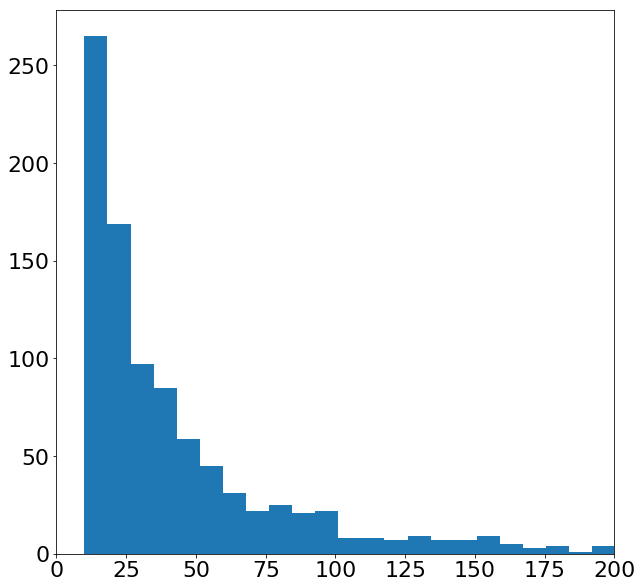

In [60]:
plt.hist(y, bins='auto') 
plt.xlim((0, 200)) 
matplotlib.rcParams.update({'font.size': 20})
plt.show()

In [19]:
pts.to_file(driver = 'ESRI Shapefile', filename= "hdbscan_labels.shp")

In [8]:
pts = gpd.read_file("/Users/codyschank/Dropbox/Insight/hdbscan_labels.shp", encoding = 'utf-8')

In [9]:
pts.columns

Index(['oa_lon', 'oa_lat', 'oa_postcod', 'oa_street_', 'oa_stree_1',
       'oa_street', 'tx25_join_', 'residentia', 'vacant', 'hdb_labels',
       'geometry'],
      dtype='object')

In [31]:
pts['geom'] = pts['geometry'].apply(lambda x: WKTElement(x.wkt, srid=3081))
pts.drop('geometry', 1, inplace=True)

In [35]:
table_name = "final_addresses_not_joined_hdbscan"
pts.head(1000).to_sql(table_name, engine, if_exists='replace', index=False, 
                        dtype={'geom': Geometry('POINT', srid= 3081)})

In [36]:
chunk_size = 1000
for i in range(1000, pts.shape[0]+chunk_size, chunk_size):
    print(i)
    pts[i:(i+chunk_size)].to_sql(table_name, engine, if_exists='append', index=False, 
                                    dtype={'geom': Geometry('POINT', srid= 3081)})

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000


In [61]:
sql_query = """
SELECT DISTINCT(vf_street_address) FROM tx25_join_3081;
"""
registered_addresses = pd.read_sql_query(sql_query,con)
registered_addresses.shape

(210355, 1)